### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

#### Ответ:

1) $2\cdot(y_{i} - a_{i})$

2) $y_{i}\cdot exp(-a(x_i)\cdot y_i)$

3) $\frac{1}{(1 + exp( -a(x_i) y_i))}\cdot y_{i}\cdot exp(-a(x_i)\cdot y_i)$


##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, ClassifierMixin
from collections import defaultdict

from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.special import expit, logsumexp

from multiprocessing.dummy import Pool, Lock, Queue
from tqdm.notebook import tqdm

from collections import namedtuple

In [2]:
class LossFunction:
    is_multi_class = False
    
    def __init__(self, n_classes):
        self.K = n_classes

    def get_init_raw_predictions(self, X, estimator):
        predictions = estimator.predict(X)
        return predictions.reshape(-1, 1).astype(np.float64)
    
    def update_terminal_regions(self, tree, X, y, residual, raw_predictions,
                                sample_weight,
                                sample_mask, learning_rate=0.1, k=0):
        terminal_regions = tree.apply(X.astype(np.float32))

        # mask all which are not in sample mask.
        masked_terminal_regions = terminal_regions.copy()
        masked_terminal_regions[~sample_mask] = -1

        # update each leaf (= perform line search)
        for leaf in np.where(tree.children_left == -1)[0]:
            self._update_terminal_region(tree, masked_terminal_regions,
                                         leaf, X, y, residual,
                                         raw_predictions[:, k], sample_weight)

        # update predictions (both in-bag and out-of-bag)
        raw_predictions[:, k] += \
            learning_rate * tree.value[:, 0, 0].take(terminal_regions, axis=0)

class MultinomialDeviance(LossFunction):

    is_multi_class = True

    def __init__(self, n_classes):
        super().__init__(n_classes)
    
    def __call__(self, y, raw_predictions, sample_weight=None):
        from scipy.special import expit, logsumexp
        """Compute the Multinomial deviance.
        Parameters
        ----------
        y : ndarray of shape (n_samples,)
            True labels.
        raw_predictions : ndarray of shape (n_samples, K)
            The raw predictions (i.e. values from the tree leaves) of the
            tree ensemble.
        sample_weight : ndarray of shape (n_samples,), default=None
            Sample weights.
        """
        # create one-hot label encoding
        Y = np.zeros((y.shape[0], self.K), dtype=np.float)
        for k in range(self.K):
            Y[:, k] = y == k

        return np.average(
            -1 * (Y * raw_predictions).sum(axis=1) +
            logsumexp(raw_predictions, axis=1),
            weights=sample_weight
        )

    def negative_gradient(self, y, raw_predictions, k=0, **kwargs):
        from scipy.special import expit, logsumexp
        """Compute negative gradient for the ``k``-th class.
        Parameters
        ----------
        y : ndarray of shape (n_samples,)
            The target labels.
        raw_predictions : ndarray of shape (n_samples, K)
            The raw predictions (i.e. values from the tree leaves) of the
            tree ensemble at iteration ``i - 1``.
        k : int, default=0
            The index of the class.
        """
        return y - np.nan_to_num(np.exp(raw_predictions[:, k] -
                                        logsumexp(raw_predictions, axis=1)))

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, raw_predictions, sample_weight):
        """Make a single Newton-Raphson step. """
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        numerator = np.sum(sample_weight * residual)
        numerator *= (self.K - 1) / self.K

        denominator = np.sum(sample_weight * (y - residual) *
                             (1 - y + residual))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

    def _raw_prediction_to_proba(self, raw_predictions):
        from scipy.special import expit, logsumexp
        return np.nan_to_num(
            np.exp(raw_predictions -
                   (logsumexp(raw_predictions, axis=1)[:, np.newaxis])))

    def _raw_prediction_to_decision(self, raw_predictions):
        proba = self._raw_prediction_to_proba(raw_predictions)
        return np.argmax(proba, axis=1)

class LeastSquaresError(LossFunction):
    """Loss function for least squares (LS) estimation 
    for binary classification.
    """
    def __init__(self, n_classes):
        if n_classes != 2:
            raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
                             .format(self.__class__.__name__, n_classes))
        # we only need to fit one model for binary clf.
        super().__init__(n_classes=1)

    def __call__(self, y, raw_predictions, sample_weight=None):
        if sample_weight is None:
            return np.mean((y - raw_predictions.ravel()) ** 2)
        else:
            return (1 / sample_weight.sum() * np.sum(
                sample_weight * ((y - raw_predictions.ravel()) ** 2)))

    def negative_gradient(self, y, raw_predictions):
        return y - raw_predictions.ravel()

    def update_terminal_regions(self, tree, X, y, residual, raw_predictions,
                                sample_weight,
                                sample_mask, learning_rate=0.1, k=0):
        raw_predictions[:, k] += learning_rate * tree.predict(X.astype(np.float32)).ravel()

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                            residual, raw_predictions):
        pass

    def _raw_prediction_to_proba(self, raw_predictions):
        from scipy.special import expit
        proba = np.ones((raw_predictions.shape[0], 2), dtype=np.float64)
        proba[:, 1] = expit(2.0 * raw_predictions.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _raw_prediction_to_decision(self, raw_predictions):
        return (raw_predictions.ravel() >= 0).astype(int)

class BinomialDeviance(LossFunction):
    def __init__(self, n_classes):
        super().__init__(n_classes=1)
    
    def __call__(self, y, raw_predictions,  sample_weight=None):
        # logaddexp(0, v) == log(1.0 + exp(v))
        raw_predictions = raw_predictions.ravel()
        if sample_weight is None:
            return -2 * np.mean((y * raw_predictions) -
                                np.logaddexp(0, raw_predictions))
        else:
            return (-2 / sample_weight.sum() * np.sum(
                sample_weight * ((y * raw_predictions) -
                                 np.logaddexp(0, raw_predictions))))

    def negative_gradient(self, y, raw_predictions):
        from scipy.special import expit
        return y - expit(raw_predictions.ravel())

    def _raw_prediction_to_proba(self, raw_predictions):
        from scipy.special import expit
        proba = np.ones((raw_predictions.shape[0], 2), dtype=np.float)
        proba[:, 1] = expit(raw_predictions.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _raw_prediction_to_decision(self, raw_predictions):
        proba = self._raw_prediction_to_proba(raw_predictions)
        return np.argmax(proba, axis=1)

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y, 
                                residual, raw_predictions, sample_weight):
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        numerator = np.sum(sample_weight * residual)
        denominator = np.sum(sample_weight *
                                (y - residual) * (1 - y + residual))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

class ExponentialLoss(LossFunction):
    """Exponential loss function for binary classification."""
    def __init__(self, n_classes):
        if n_classes != 2:
            raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
                             .format(self.__class__.__name__, n_classes))
        # we only need to fit one model for binary clf.
        super().__init__(n_classes=1)
    
    def __call__(self, y, raw_predictions, sample_weight=None):
        raw_predictions = raw_predictions.ravel()
        if sample_weight is None:
            return np.mean(np.exp(-(2. * y - 1.) * raw_predictions))
        else:
            return (1.0 / sample_weight.sum() * np.sum(
                sample_weight * np.exp(-(2 * y - 1) * raw_predictions)))

    def negative_gradient(self, y, raw_predictions):
        y_ = -(2. * y - 1.)
        return y_ * np.exp(y_ * raw_predictions.ravel())

    def _raw_prediction_to_proba(self, raw_predictions):
        from scipy.special import expit
        proba = np.ones((raw_predictions.shape[0], 2), dtype=np.float)
        proba[:, 1] = expit(2.0 * raw_predictions.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _raw_prediction_to_decision(self, raw_predictions):
        return (raw_predictions.ravel() >= 0).astype(int)

    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y, 
                                residual, raw_predictions, sample_weight):
        terminal_region = np.where(terminal_regions == leaf)[0]
        raw_predictions = raw_predictions.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        sample_weight = sample_weight.take(terminal_region, axis=0)

        y_ = 2. * y - 1.

        numerator = np.sum(y_ * sample_weight * np.exp(-y_ * raw_predictions))
        denominator = np.sum(sample_weight * np.exp(-y_ * raw_predictions))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = numerator / denominator

LOSS_FUNCTIONS = {
    "squared_error": LeastSquaresError,
    'deviance': BinomialDeviance,
    'exponential': ExponentialLoss,
}

In [3]:
class MyGradientBoostingClassifier(ClassifierMixin):
    """
    subsample : float, default=1.0
        The fraction of samples to be used for fitting the individual base
        learners.
    init_model : estimator or 'zero', default=None
        An estimator object that is used to compute the initial predictions.
    max_features : {'auto', 'sqrt', 'log2'}, int or float, default=None
        The number of features to consider when looking for the best split.
    """
    DEFAULT_PARAMS_TREE = {'criterion': 'mse',
                           'min_samples_split': 2,
                           'max_depth': 3}

    DEFAULT_PARAMS_SVM = {'kernel': 'rbf',
                          'degree': 3,
                          'gamma': 'scale',
                          'C': 1.0,
                          'max_iter':-1}
    DEFAULT_PARAMS_LOGREG = {'C': 1.0, 'max_iter': 2000}
    
    DEFAULT_PARAMS_RF = {'max_samples': 0.5, 'n_jobs': -1}
    
    def __init__(self, loss='deviance', learning_rate=0.1, n_estimators=100, 
                 subsample = 1.0,
                 max_features = 1.0,
                 init_model_class=None,
                 base_model_class = DecisionTreeRegressor,
                 *args, **base_model_params):
        """
        loss -- один из 3 лоссов
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        max_features -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss = loss
        self.subsample = subsample
        self.max_features = max_features
        
        self.init_model_class = init_model_class
        if self.init_model_class is None:
            self.init_ = 'zero'
        else:
            if self.init_model_class == LogisticRegression:
                self.init_ = self.init_model_class(**DEFAULT_PARAMS_LOGREG)
            else:
                self.init_ = self.init_model_class()
            
        self.base_model_class = base_model_class
        if self.base_model_class == DecisionTreeRegressor:
            self.base_model_params = MyGradientBoostingClassifier.DEFAULT_PARAMS_TREE.copy()
            self.base_model_params.update(base_model_params)
            self.base_model_params['max_features'] = self.max_features
        elif self.base_model_class == RandomForestRegressor:
            self.base_model_params = MyGradientBoostingClassifier.DEFAULT_PARAMS_RF.copy()
            self.base_model_params.update(base_model_params)
            self.base_model_params['max_features'] = self.max_features
        elif self.base_model_class == SVR:
            self.base_model_params = MyGradientBoostingClassifier.DEFAULT_PARAMS_SVM.copy()
            self.base_model_params.update(base_model_params)
        else:
            raise ValueError(f"base_model '{base_model_class}' is not recognized")

    def factory_base_model(self):
        return self.base_model_class(**self.base_model_params)

    def _clear_state(self):
        """Clear the state of the gradient boosting model. """
        if hasattr(self, 'estimators_'):
            self.estimators_ = np.empty((0, 0), dtype=object)

    def _init_state(self):
        self.estimators_ = np.empty((self.n_estimators, self.loss_.K),
                                    dtype=object)

    def _is_initialized(self):
        return len(getattr(self, 'estimators_', [])) > 0

    def fit(self, X, y):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        sample_weight = np.ones(X.shape[0])
        self._clear_state()

        y = np.asarray(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)

        if self.loss == 'deviance':
            loss_class = (MultinomialDeviance
                          if len(self.classes_) > 2
                          else BinomialDeviance)
        else:
            loss_class = LOSS_FUNCTIONS[self.loss]

        self.loss_ = loss_class(self.n_classes_)

        X_val = y_val = sample_weight_val = None

        if not self._is_initialized():
            # init state
            self._init_state()
            # fit initial model and initialize raw predictions
            if self.init_ == 'zero':
                raw_predictions = np.zeros(shape=(X.shape[0], self.loss_.K),
                                           dtype=np.float)
            else:
                if isinstance(self.init_, SVC):
                    if not hasattr(self, 'fit_status_'):
                        self.init_.fit(X, y)
                else:
                    self.init_.fit(X, y)
                
                raw_predictions = \
                    self.loss_.get_init_raw_predictions(X, self.init_)

            begin_at_stage = 0

        # fit the boosting stages
        n_stages = self._fit_stages(
            X, y, raw_predictions, sample_weight, 
            X_val, y_val, sample_weight_val, 
            begin_at_stage)

        self.n_estimators_ = n_stages
        return self

    def predict(self, X):
        # Ваш код здесь
        if self.init_ == 'zero':
            raw_predictions = np.zeros(shape=(X.shape[0], self.loss_.K), dtype=np.float)
        else:
            raw_predictions = self.loss_.get_init_raw_predictions(X, self.init_).astype(np.float)
        
        for k in range(self.loss_.K):
            for i in range(self.n_estimators):
                if self.base_model_class in (DecisionTreeRegressor, RandomForestRegressor):
                    raw_predictions[:, k] += self.learning_rate * self.estimators_[i, k].predict(X).astype(np.float)
                else:
                    estimator, feature_indices = self.estimators_[i, k]
                    raw_predictions[:, k] += self.learning_rate * estimator.predict(X[:, feature_indices]).astype(np.float)
        
        encoded_labels = \
            self.loss_._raw_prediction_to_decision(raw_predictions)
        return self.classes_.take(encoded_labels, axis=0)

    def _fit_stage(self, i, X, y, raw_predictions, sample_weight, sample_mask, feature_indices):
        """Fit another stage of ``_n_classes`` models to the boosting model."""
        loss = self.loss_
        original_y = y

        # For base_model_class == DecisionTreeRegressor:
        # Need to pass a copy of raw_predictions to negative_gradient()
        # because raw_predictions is partially updated at the end of the loop
        # in update_terminal_regions(), and gradients need to be evaluated at
        # iteration i - 1.
        raw_predictions_copy = raw_predictions.copy()

        # Classification with more than 2 classes requires the induction of n_classes regression models 
        # at each iteration, thus, the total number of induced trees equals n_classes * n_estimators.
        for k in range(loss.K):
            if loss.is_multi_class:
                y = np.array(original_y == k, dtype=np.float)

            residual = loss.negative_gradient(y, raw_predictions_copy)

            # induce regression base model on residuals
            model = self.factory_base_model()

            if self.subsample < 1.0:
                # no inplace multiplication!
                sample_weight = sample_weight * sample_mask.astype(np.float)
            
            if self.base_model_class == DecisionTreeRegressor:
                model.fit(X, residual, sample_weight=sample_weight, check_input=False)
            elif self.base_model_class == RandomForestRegressor:
                model.fit(X, residual, sample_weight=sample_weight)
            else:
                model.fit(X[:, feature_indices], residual, sample_weight=sample_weight)

            # update tree leaves
            if self.base_model_class == DecisionTreeRegressor:
                loss.update_terminal_regions(
                    model.tree_, X, y, residual, raw_predictions, sample_weight,
                    sample_mask, learning_rate=self.learning_rate, k=k)
            elif self.base_model_class == RandomForestRegressor:
                new_raw_predictions = model.predict(X)
                raw_predictions[:, k] += self.learning_rate * new_raw_predictions
            else:
                new_raw_predictions = model.predict(X[:, feature_indices])
                raw_predictions[:, k] += self.learning_rate * new_raw_predictions
                
            # add model to ensemble
            if self.base_model_class in (DecisionTreeRegressor, RandomForestRegressor):
                self.estimators_[i, k] = model
            else:
                self.estimators_[i, k] = (model, feature_indices)

        return raw_predictions

    def _fit_stages(self, X, y, raw_predictions, sample_weight,
                    X_val, y_val, sample_weight_val,
                    begin_at_stage=0):
        n_samples = X.shape[0]
        n_features = X.shape[1]
        do_oob = self.subsample < 1.0
        sample_mask = np.ones((n_samples, ), dtype=bool)
        n_inbag = max(1, int(self.subsample * n_samples))
        n_inbag_features = max(1, int(self.max_features * n_features))
        loss_ = self.loss_

        # perform boosting iterations
        i = begin_at_stage

        for i in range(begin_at_stage, self.n_estimators):
            # subsampling
            sample_mask = np.zeros((n_samples,), dtype=bool)
            sample_indices =  np.random.choice(n_samples, n_inbag, replace=False)
            sample_mask[sample_indices] = True
            feature_indices =  np.random.choice(n_features, n_inbag_features, replace=False)
            # fit next stage of trees
            raw_predictions = self._fit_stage(i, X, y, raw_predictions, sample_weight, sample_mask, feature_indices)

        return i + 1

### Многоклассовaя классификация:

In [36]:
my_clf_tree = MyGradientBoostingClassifier(loss='deviance', n_estimators=100, learning_rate=0.1,
                                           max_features=0.5, subsample=0.5,
                                           base_model_class=DecisionTreeRegressor,
                                           min_samples_split=3, max_depth=6)
my_clf_svm = MyGradientBoostingClassifier(loss='deviance', n_estimators=100, learning_rate=0.1, 
                                          max_features=0.5, subsample=0.5, 
                                          base_model_class=SVR)
clf = GradientBoostingClassifier(loss='deviance', n_estimators=100, learning_rate=0.1,
                                 min_samples_split=3, max_depth=6,
                                 max_features=0.5, subsample=0.5)

In [37]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, 
                                                    test_size=0.1, stratify=wine.target,
                                                    random_state=0)

In [38]:
my_clf_tree.fit(X_train, y_train)
my_clf_svm.fit(X_train, y_train)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, max_features=0.5, min_samples_split=3,
                           subsample=0.5)

In [39]:
print(f"clf accuracy_score = {accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)}")
print(f"my_clf_tree accuracy_score = {accuracy_score(y_pred=my_clf_tree.predict(X_test), y_true=y_test)}")
print(f"my_clf_svm accuracy_score = {accuracy_score(y_pred=my_clf_svm.predict(X_test), y_true=y_test)}")

clf accuracy_score = 1.0
my_clf_tree accuracy_score = 1.0
my_clf_svm accuracy_score = 0.7777777777777778


Видно,что SVM работает хуже в качестве базовой модели, чем DecisionTreeRegressor при заданных параметрах (n_estimators=100, learning_rate=0.1).

### Бинарная классификация:

In [40]:
breast_cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, 
                                                    test_size=0.1, stratify=breast_cancer.target, random_state=42)

In [48]:
my_clf_tree = MyGradientBoostingClassifier(loss='exponential', n_estimators=100, learning_rate=0.1,
                                           max_features=0.5, subsample=0.5,
                                           base_model_class=DecisionTreeRegressor,
                                           min_samples_split=3, max_depth=6)
clf = GradientBoostingClassifier(loss='exponential', n_estimators=100, learning_rate=0.1,
                                 min_samples_split=3, max_depth=6,
                                 max_features=0.5, subsample=0.5)

In [49]:
my_clf_tree.fit(X_train, y_train)
clf.fit(X_train, y_train)

GradientBoostingClassifier(loss='exponential', max_depth=6, max_features=0.5,
                           min_samples_split=3, subsample=0.5)

In [51]:
print(f"clf accuracy_score = {accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)}")
print(f"my_clf_tree accuracy_score = {accuracy_score(y_pred=my_clf_tree.predict(X_test), y_true=y_test)}")

clf accuracy_score = 0.9473684210526315
my_clf_tree accuracy_score = 0.9649122807017544


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [52]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [53]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [54]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [55]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=132)

#### Вспомогательная функция cross_val_score:

In [19]:
def cross_val_score(param_grid_value, wo_lock=False):
    global cv
    global X_train
    global y_train
    global init_model_class
    global base_model_class
    train_scores = []
    valid_scores = []
    my_clf = MyGradientBoostingClassifier(
            n_estimators = 100,
            loss='deviance', learning_rate=0.1,
            max_features=0.5, subsample=0.5,
            init_model_class=init_model_class,
            base_model_class=base_model_class)
    for train_idx, test_idx in cv.split(X_train, y_train):
        X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
        y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
        my_clf.loss = param_grid_value.loss
        my_clf.learning_rate = param_grid_value.learning_rate
        my_clf.n_estimators = param_grid_value.n_estimators
        my_clf.fit(X_train_f, y_train_f)
        valid_scores.append(my_clf.score(X_test_f, y_test_f))
        train_scores.append(my_clf.score(X_train_f, y_train_f))
    if not wo_lock:
        with lock:
            pbar.update(1)
    return ParamGridResult(param_grid_value.n_estimators,
                           param_grid_value.learning_rate,
                           param_grid_value.loss,
                           train_scores, valid_scores)

In [9]:
ParamGridValue = namedtuple("ParamGridValue", ["n_estimators", "learning_rate", "loss"])
ParamGridResult = namedtuple("ParamGridResult", ["n_estimators", "learning_rate", "loss", 
                                                 "train_scores", "valid_scores"])

In [10]:
def get_param_grid(param_dict):
    loss_list = np.repeat(param_grid['loss'], 
                      len(param_grid['learning_rate']))
    loss_list = np.repeat(np.asarray(loss_list).reshape(-1, 1), 
                      len(param_grid['n_estimators']), axis=1).T.ravel()
    
    learning_rate_list = np.repeat(
        np.asarray(param_grid['learning_rate']).reshape(-1, 1),
        len(param_grid['n_estimators']) * len(param_grid['loss']), axis=1).T.ravel()
    
    n_estimators_list = np.repeat(
        np.asarray(param_grid['n_estimators']),
        len(param_grid['learning_rate']) * len(param_grid['loss']))
    
    param_tuples = [
         ParamGridValue(n_estimators, learning_rate, loss) 
         for n_estimators, loss, learning_rate in list(zip(n_estimators_list, loss_list, learning_rate_list))]
    return param_tuples          

In [11]:
def plot_accuracies(param_name, param_values, train_scores, valid_scores, fig=None, init_model_name='zero', add_subplot=111):
    if fig is None:
        fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(add_subplot)
    train_score_mean = train_scores.mean(axis=1)
    train_score_std = train_scores.std(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)
    valid_scores_std = valid_scores.std(axis=1)

    plt.fill_between(param_values, train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                     interpolate=True, alpha=0.5,)
    plt.fill_between(param_values, valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                     interpolate=True, alpha=0.5)

    plt.plot(param_values, train_score_mean, c='b', lw=2, label="Training score")
    plt.plot(param_values, valid_scores_mean, c='r', lw=2, label="Cross-validation score")


    plt.xlabel('n_estimators')
    plt.ylabel('accuracy')
    plt.legend(loc="best")
    plt.title(
        f"""Validation Curve with init_model {init_model_name} ({param_name} vs. accuracy)""")

#### Вычисление scores для графика:

In [153]:
param_grid = {'loss': ['deviance'],
              'learning_rate': [0.1],
              'n_estimators': range(1, 101)}
param_grid = get_param_grid(param_grid)

In [157]:
init_model_class = RandomForestClassifier
with Pool(processes=8) as pool, tqdm(total=len(param_grid)) as pbar:
    lock = pbar.get_lock()
    scores_rf = pool.map(cross_val_score, param_grid)
pool.join()

In [154]:
init_model_class = None
with Pool(processes=8) as pool, tqdm(total=len(param_grid)) as pbar:
    lock = pbar.get_lock()
    scores_zero = pool.map(cross_val_score, param_grid)
pool.join()

In [158]:
scores_rf = sorted(scores_rf, key=operator.itemgetter(ParamGridResult._fields.index('n_estimators')))
scores_zero = sorted(scores_zero, key=operator.itemgetter(ParamGridResult._fields.index('n_estimators')))

In [160]:
train_scores_rf = [r.train_scores for r in scores_rf]
valid_scores_rf = [r.valid_scores for r in scores_rf]
train_scores_rf = np.asarray(train_scores_rf)
valid_scores_rf = np.asarray(valid_scores_rf)

train_scores_zero = [r.train_scores for r in scores_zero]
valid_scores_zero = [r.valid_scores for r in scores_zero]
train_scores_zero = np.asarray(train_scores_zero)
valid_scores_zero = np.asarray(valid_scores_zero)

### 1. Построить график точности в зависимости от числа итераций на валидации:

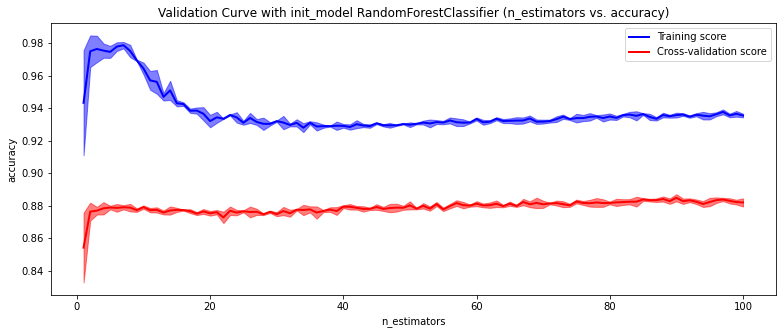

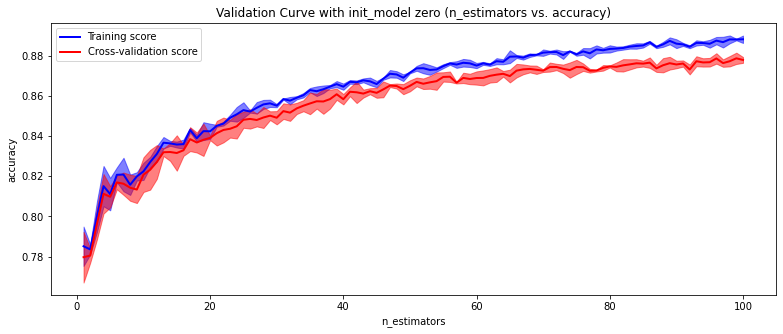

In [161]:
plot_accuracies('n_estimators', range(1, 101), 
                train_scores_rf, valid_scores_rf, init_model_name='RandomForestClassifier')
plot_accuracies('n_estimators', range(1, 101), 
                train_scores_zero, valid_scores_zero, init_model_name='zero')

Видно, что с увеличением кол-ва итерации (n_estimators) растет точность при init_model = 'zero' (константа).

При это если init_model = RandomForestClassifier, то первоначальное приближение уже блико к 1.0 на train (0.98), поэтому с ростом кол-ва итерации качество на валидации не улучшается.

### 2. Подобрать оптимальные параметры Вашего бустинга на валидации:

In [12]:
param_grid = {'loss': ['squared_error', 'deviance', 'exponential'],
              'learning_rate': np.arange(0.1, 1.1, 1e-1),
              'n_estimators': [100]}
param_grid = get_param_grid(param_grid)

In [13]:
init_model_class = None

In [19]:
with Pool(processes=8) as pool, tqdm(total=len(param_grid)) as pbar:
    lock = pbar.get_lock()
    results = pool.map(cross_val_score, param_grid)
pool.join()

In [20]:
idx_max = np.argmax(list(map(lambda x: np.mean(x.valid_scores), results)))
best_params = results[idx_max]

#### Оптимальные параметры:

In [21]:
print(f"loss - {best_params.loss}")
print(f"learning_rate - {best_params.learning_rate}")
print(f"best_score on valid - {np.mean(best_params.valid_scores)}")

loss - exponential
learning_rate - 0.30000000000000004
best_score on valid - 0.8873815676141258


In [23]:
best_model = MyGradientBoostingClassifier(
    n_estimators = 100,
    loss='exponential', learning_rate=0.3,
    max_features=0.5, subsample=0.5)

In [24]:
best_model.fit(X_train, y_train)

In [25]:
print(f"best_model accuracy_score on test = {best_model.score(X_test, y_test)}")

best_model accuracy_score on test = 0.8880813953488372


## BooBag BagBoo (1 балл)

Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

#### Вспомогательные функции:

In [20]:
def closs_val_score_bagging(n_estimators, wo_lock=False):
    global base_model_params
    bagger = MyBaggingClassifier(base_model_class=MyGradientBoostingClassifier, 
                                 n_base_models=n_estimators, 
                                 base_model_params=base_model_params)
    valid_scores = []
    train_scores = []
    for train_idx, test_idx in cv.split(X_train, y_train):
        X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
        y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
        bagger.fit(X_train_f, y_train_f)
        valid_scores.append(bagger.score(X_test_f, y_test_f))
        train_scores.append(bagger.score(X_train_f, y_train_f))
    if not wo_lock:
        with lock:
            pbar.update(1)
    return ParamGridResult(n_estimators, None, None,
                           train_scores, valid_scores)

#### 1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn):

In [13]:
param_grid = {'loss': ['deviance', 'exponential'],
              'learning_rate': np.arange(0.1, 1.1, 1e-1),
              'n_estimators': range(20, 51)}
param_grid = get_param_grid(param_grid)

In [ ]:
init_model_class = None
base_model_class = RandomForestRegressor

with Pool(processes=8) as pool, tqdm(total=len(param_grid)) as pbar:
    lock = pbar.get_lock()
    results = pool.map(cross_val_score, param_grid)
pool.join()

In [182]:
idx_max = np.argmax(list(map(lambda x: np.mean(x.valid_scores), results)))
best_params_BooBag = results[idx_max]
print(f"loss - {best_params_BooBag.loss}")
print(f"learning_rate - {best_params_BooBag.learning_rate}")
print(f"n_estimators - {best_params_BooBag.n_estimators}")
print(f"best_score on valid - {np.mean(best_params_BooBag.valid_scores)}")

loss - deviance
learning_rate - 0.4
n_estimators - 48
best_score on valid - 0.881782945736434


In [21]:
init_model_class = None
base_model_class = RandomForestRegressor
best_params_BooBag = ParamGridValue(48, 0.4, "deviance")
scores_BooBag = cross_val_score(best_params_BooBag, wo_lock=True)

In [32]:
print(f"BooBag_score on valid - {np.mean(scores_BooBag.valid_scores)}")

BooBag_score on valid - 0.8889427217915591


#### 2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять:

Поскольку estimator MyGradientBoostingClassifier.__init__() не удовлетворяет требованиям scikit-learn.

Так как по данному зададнию имеет сигнатуру __init__()(..., *args, **base_model_params) не удовлетворяющую требованиям.

То используем вспомогательный класс MyBaggingClassifier.

In [35]:
class MyBaggingClassifier(ClassifierMixin):
    
    def __init__(self, base_model_class, n_base_models, **base_model_params):
        """
        Initialize instance of BaggingClassifier (build base models)
        :param base_model_class: class (not instance!) of a model to be used as base model
        :param n_base_models: int number of base models to use in bagging
        :param **base_model_params: **kwargs of params to pass to base_models .init() method
        """
        self.n_base_models = n_base_models
        self.base_models = [self._create_model_(base_model_class, **base_model_params) 
                            for _ in range(self.n_base_models)]
    
    def _create_model_(self, base_model_class, **base_model_params):
        return base_model_class(n_estimators=base_model_params['base_model_params']['n_estimators'],
                                loss=base_model_params['base_model_params']['loss'],
                                learning_rate=base_model_params['base_model_params']['learning_rate'],
                                max_features=base_model_params['base_model_params']['max_features'],
                                subsample=base_model_params['base_model_params']['subsample'],
                                base_model_class=base_model_params['base_model_params']['base_model_class'])
    
    def _create_bagging_subsample_(self, X, y):
        """
        Create subsample of X using bagging sampling
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets
        :return X_bagging: array-like features of subsample 
        :return y_bagging: array-like targets of subsample
        """
        subsample = 0.5
        n_samples = X.shape[0]
        n_inbag = max(1, int(subsample * n_samples))
        indices = np.random.choice(n_samples, n_inbag)
        X_bagging, y_bagging = X[indices,:], y[indices]
        #TODO: your code here
        return X_bagging, y_bagging
        
    def fit(self, X, y):
        """
        Train classifier by calling .train() method of base models
        :param X: array-like features (n_obj x n_features)
        :param y: array-like targets
        """
        self.classes_, y = np.unique(y, return_inverse=True)
        for base_model in self.base_models:
            X_bagging, y_bagging = self._create_bagging_subsample_(X, y)
            base_model.fit(X_bagging, y_bagging)
    
    def _raw_prediction_to_proba(self, raw_predictions):
        from scipy.special import expit
        proba = np.ones((raw_predictions.shape[0], 2), dtype=np.float)
        proba[:, 1] = expit(raw_predictions.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def _raw_prediction_to_decision(self, raw_predictions):
        proba = self._raw_prediction_to_proba(raw_predictions)
        return np.argmax(proba, axis=1)

    def predict(self, X):
        """
        Make prediction for X using .predict() method of base models and simple voting
        :param X: array-like features (n_obj x n_features)
        :return results: array-like target predictions (n_obj)
        """
        # N_objects x N_base_models
        base_models_predictions = np.asarray([
            base_model.predict(X) for base_model in self.base_models], 
            dtype=np.int).transpose(1, 0)  
        raw_predictions = np.mean(base_models_predictions, axis=1)
        encoded_labels = self._raw_prediction_to_decision(raw_predictions)
        return self.classes_.take(encoded_labels, axis=0)
        #TODO: your code here - handle base model format
        return np.asarray(result)
    
    def predict_proba(self, X):
        """
        Make probability prediction for X using .predict_proba() method of base models and averaging them
        :param X: array-like features (n_obj x n_features)
        :return results: array-like target probabilities predictions (n_obj x n_classes)
        """
        # N_objects xы N_base_models x N_classes
        base_models_predictions = np.asarray([base_model.predict_proba(X) 
                                              for base_model in self.base_models], dtype=np.float).transpose(1, 0, 2)  
        return base_models_predictions.mean(axis=1)

In [25]:
base_model_params = {
    'n_estimators': 100,
    'loss': 'deviance', 
    'learning_rate': 0.4,
    'max_features': 0.5, 
    'subsample': 0.5,
    'base_model_class': DecisionTreeRegressor}

In [27]:
param_range = range(1, 51)

In [28]:
with Pool(processes=8) as pool, tqdm(total=len(param_range)) as pbar:
    lock = pbar.get_lock()
    results_BagBoo = pool.map(closs_val_score_bagging, param_range)
pool.join()

In [30]:
idx_max = np.argmax(list(map(lambda x: np.mean(x.valid_scores), results_BagBoo)))
best_params_BagBoo = results_BagBoo[idx_max]
print(f"n_estimators - {best_params_BagBoo.n_estimators}")
print(f"best_score on valid - {np.mean(best_params_BagBoo.valid_scores)}")

n_estimators - 1
best_score on valid - 0.8743001722652886


In [26]:
scores_BagBoo = closs_val_score_bagging(1, wo_lock=True)

In [33]:
print(f"BagBoo_score on valid - {np.mean(scores_BagBoo.valid_scores)}")

BagBoo_score on valid - 0.8745693367786392


#### Сравнение BooBag (1) и BagBoo (2)

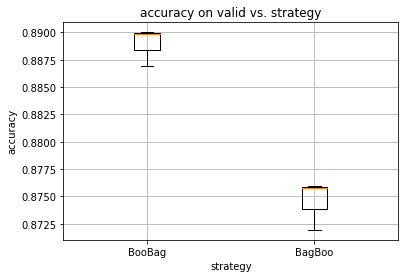

In [34]:
data = [scores_BooBag.valid_scores, scores_BagBoo.valid_scores]
fig, ax = plt.subplots()
ax.set_title('accuracy on valid vs. strategy')
ax.boxplot(data, labels=['BooBag', 'BagBoo'])
plt.grid()
plt.xlabel('strategy')
plt.ylabel('accuracy')
plt.show()

#### Ответ:

С заданными параметрами BooBag (88.8 %) немного лучше по качеству на валидации, чем BagBoo (87.4 %).

Но в целом качество на валидации (88.8 %), полученное при бустинге, не улучшено.

При поиске гиперпараметров (n_estimators) на валидации для BagBoo получилось n_estimators = 1, то есть BagBoo с такими параметрами эквивалентен бустингу. Поэтому качество не лучше.

В бустинге для базовых моделей (DecisionTreeRegressor) использовались параметры sample_weight, max_features.
Поэтому бустинг с такими параметрами базовых моделей в принципе эквивалентен RandomForest.
В свою очередь BooBag (бустинг с base_model = RandomForest) - это линейная комбинация RandomForest.
То есть модели в принципе одного класса сложности.
Поэтому полученное качество на валидации у них сравнимо.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [94]:
param_grid = {'loss': [best_params.loss],
              'learning_rate': [best_params.learning_rate],
              'n_estimators': [best_params.n_estimators]}

In [95]:
param_grid = get_param_grid(param_grid)

In [113]:
init_model_class = SVC
scores_svc = cross_val_score(param_grid[0])

In [114]:
init_model_class = LogisticRegression
scores_logreg = cross_val_score(param_grid[0])

In [122]:
init_model_class = RandomForestClassifier
scores_rf = cross_val_score(param_grid[0])

In [128]:
init_model_class = None
scores_zero = cross_val_score(param_grid[0])

#### Ответ:


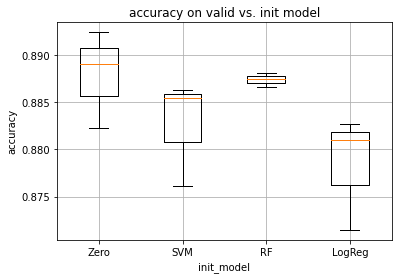

In [130]:
data = [scores_zero.valid_scores, scores_svc.valid_scores, 
        scores_rf.valid_scores, scores_logreg.valid_scores]
fig, ax = plt.subplots()
ax.set_title('accuracy on valid vs. init model')
ax.boxplot(data, labels=['Zero', 'SVM', 'RF', 'LogReg'])
plt.grid()
plt.xlabel('init_model')
plt.ylabel('accuracy')
plt.show()

Качество модели на валидации не улучшилось (с учетом фиксированного для всех вариантов n_estimators).
Построенная последовательность моделей (base_model) исправляет ошибки init_model.
Поэтому качество особо не зависит от первоначального приближения (init_model) при заданном n_estimators.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

